## Import necessary libraries

In [50]:

import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.io import imread
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns





The original dataset can be found at: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/data

The dataset is a collection of MRI images of patients with Alzheimer's disease and healthy individuals. It's already preprocessed and split into training and testing sets.

In the following code, we split 15% of the training set into a validation set.

In [ ]:
source_train_dir = './original_data/train'
source_test_dir = './original_data/test'
target_base = 'data'

split_ratios = [0.85, 0.15]

#Limpeza caso já tenha sido executado este bloco antes
for subset in ['train', 'val', 'test']:
    subset_path = os.path.join(target_base, subset)
    if os.path.exists(subset_path):
        print(f"Removing old {subset} directory...")
        shutil.rmtree(subset_path)

for class_name in os.listdir(source_train_dir):
    class_path = os.path.join(source_train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if not f.startswith('.')] 
    random.shuffle(files)

    total = len(files)
    train_end = int(split_ratios[0] * total)

    train_files = files[:train_end]
    val_files = files[train_end:]

    print(f"{class_name}: Total={total}, Train={len(train_files)}, Val={len(val_files)}")

    for split, split_files in zip(['train', 'val'], [train_files, val_files]):
        split_dir = os.path.join(target_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for file in split_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(split_dir, file)
            shutil.copy2(src, dst)

for class_name in os.listdir(source_test_dir):
    class_path = os.path.join(source_test_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(target_base, 'test', class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    test_files = [f for f in os.listdir(class_path) if not f.startswith('.')]
    print(f"{class_name} Test: {len(test_files)} images")

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(target_class_dir, file)
        shutil.copy2(src, dst)


Removing old train directory...
Removing old val directory...
Removing old test directory...
Moderate Impairment: Total=2560, Train=2176, Val=384
Mild Impairment: Total=2560, Train=2176, Val=384
No Impairment: Total=2560, Train=2176, Val=384
Very Mild Impairment: Total=2560, Train=2176, Val=384
Moderate Impairment Test: 12 images
Mild Impairment Test: 179 images
No Impairment Test: 640 images
Very Mild Impairment Test: 448 images


In the next code block, we print and plot important information about the dataset, including the number of images in each class and subset and also the distribution of images in each class.

Distribution of Images in Each Subset:
Mild Impairment: Train: 2176, Val: 384, Test: 179
Moderate Impairment: Train: 2176, Val: 384, Test: 12
No Impairment: Train: 2176, Val: 384, Test: 640
Very Mild Impairment: Train: 2176, Val: 384, Test: 448


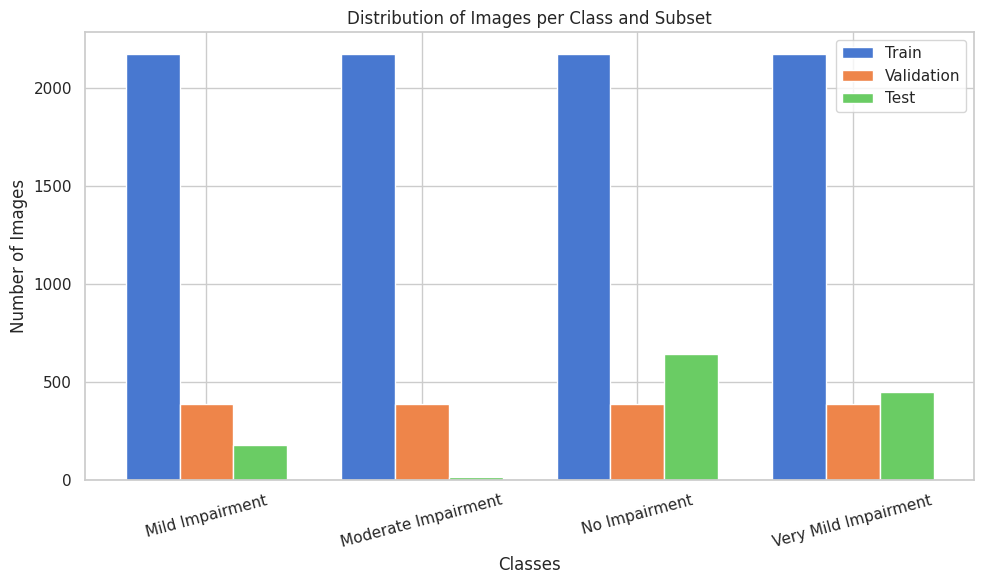

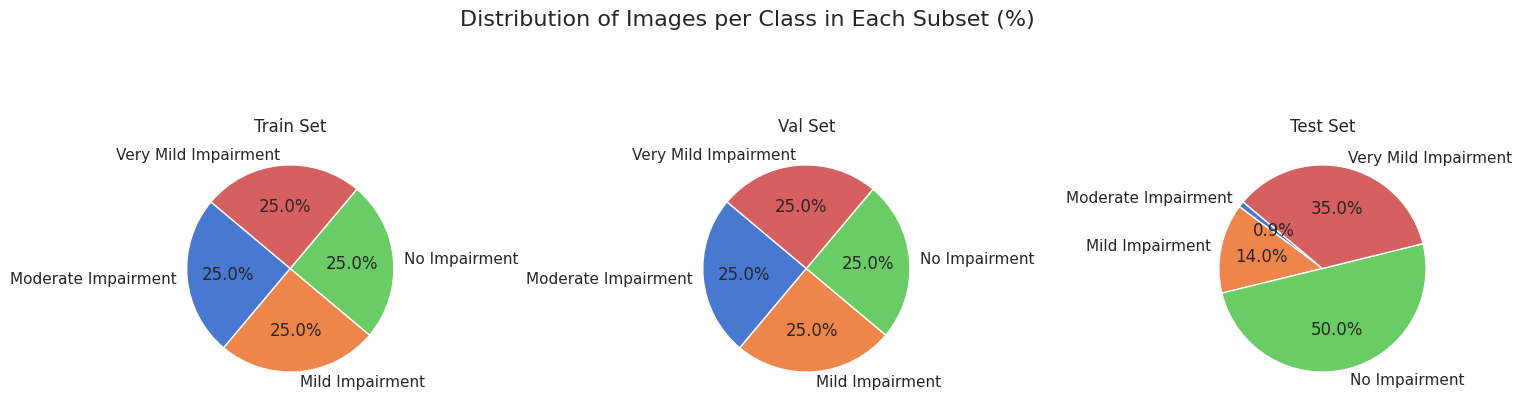

In [56]:
base_path = "./data" 

data_counts = {
    "train": defaultdict(int),
    "val": defaultdict(int),
    "test": defaultdict(int)
}

for subset in data_counts.keys():
    subset_path = os.path.join(base_path, subset)
    for label in os.listdir(subset_path):
        label_path = os.path.join(subset_path, label)
        count = len(os.listdir(label_path))
        data_counts[subset][label] = count

labels = sorted(list(data_counts["train"].keys()))
x = range(len(labels))
bar_width = 0.25

train_counts = [data_counts["train"][label] for label in labels]
val_counts = [data_counts["val"][label] for label in labels]
test_counts = [data_counts["test"][label] for label in labels]

print("Distribution of Images in Each Subset:")
for label in labels:
    print(f"{label}: Train: {data_counts['train'][label]}, Val: {data_counts['val'][label]}, Test: {data_counts['test'][label]}")

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], train_counts, width=bar_width, label='Train')
plt.bar(x, val_counts, width=bar_width, label='Validation')
plt.bar([i + bar_width for i in x], test_counts, width=bar_width, label='Test')

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class and Subset")
plt.xticks(ticks=x, labels=labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, subset in enumerate(["train", "val", "test"]):
    counts = data_counts[subset]
    axes[i].pie(
        counts.values(),
        labels=counts.keys(),
        autopct='%1.1f%%',
        startangle=140
    )
    axes[i].set_title(f"{subset.capitalize()} Set")

plt.suptitle("Distribution of Images per Class in Each Subset (%)", fontsize=16)
plt.tight_layout()
plt.show()


rogosidade, luminosidade, contornos, areas
ferrramentas de processamento de imagem médica ( python, kaggle, ...)
para nos dar as features

CNN ESTUDAR AS CAMADAS E VER OQ ELAS ESTAO A FAZER
neurokit
machine learning com estas features vs deep learning


Here we plot a few sample images from the dataset to visualize the data.

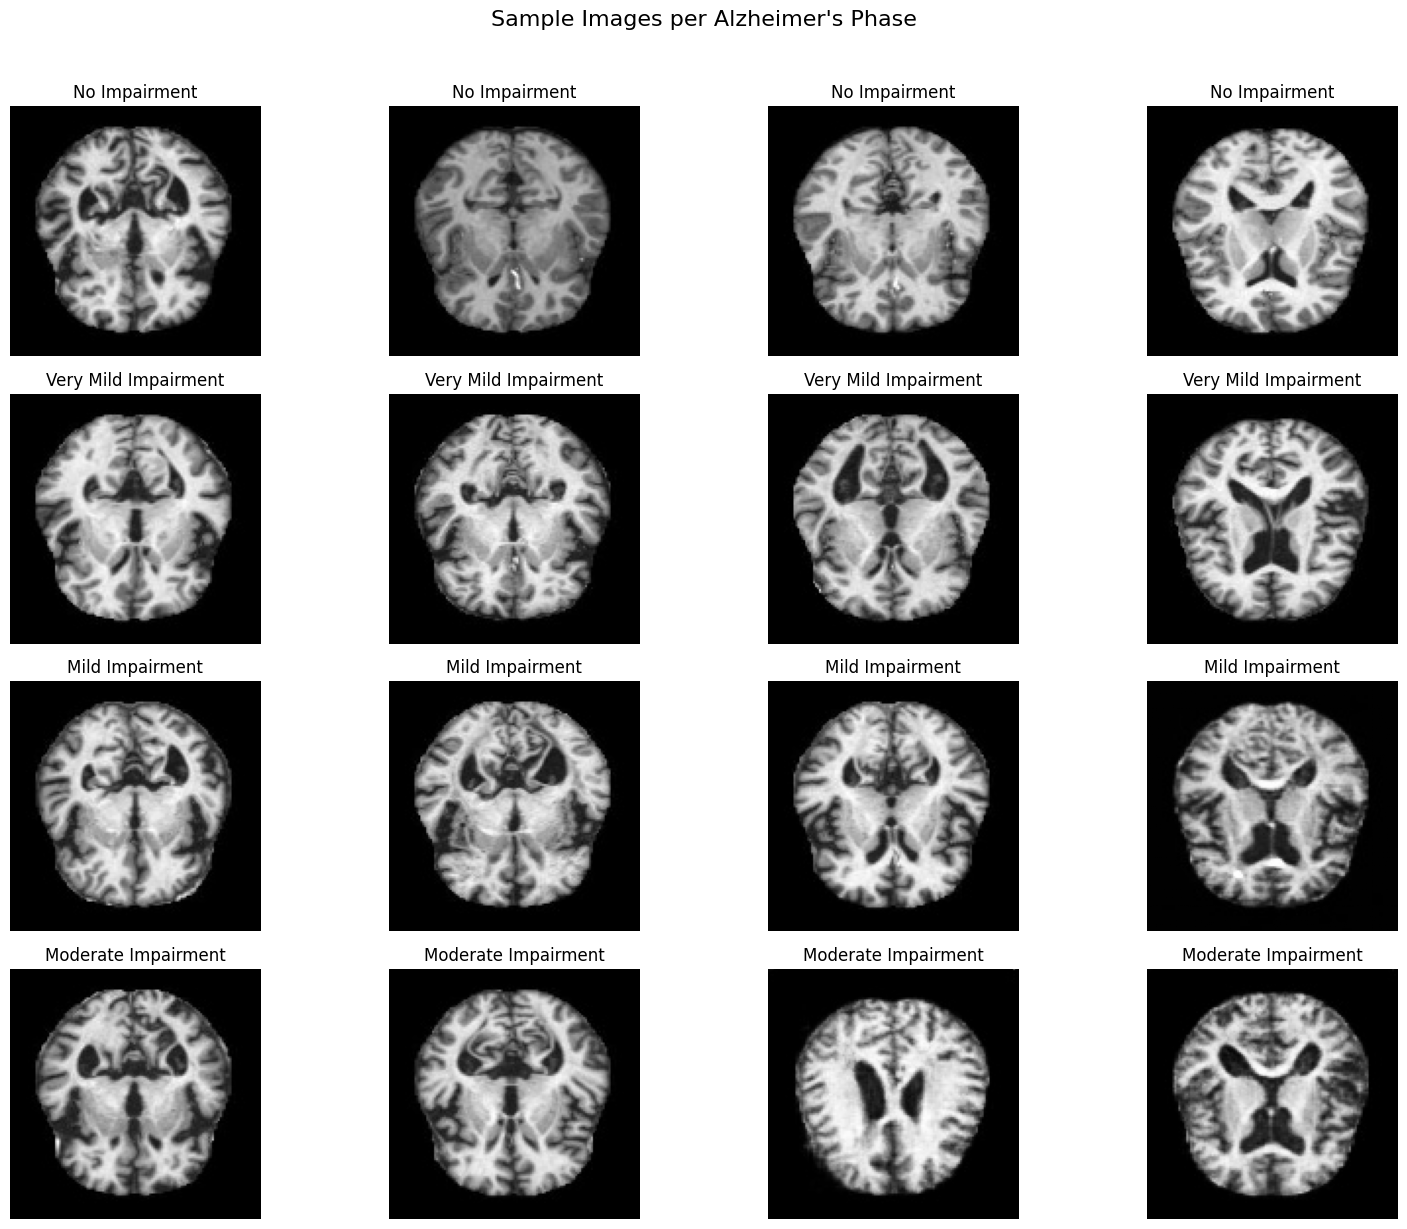

In [20]:

dataset_path = "./data/train" 

ordered_classes = [
    "No Impairment",          
    "Very Mild Impairment",   
    "Mild Impairment",        
    "Moderate Impairment"     
]

available_classes = os.listdir(dataset_path)
classes = [cls for cls in ordered_classes if cls in available_classes]

n_images = 4

plt.figure(figsize=(n_images * 4, len(classes) * 3))
img_index = 1

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    for i in range(min(n_images, len(images))):
        img_path = os.path.join(class_path, images[i])
        try:
            img = Image.open(img_path)
            plt.subplot(len(classes), n_images, img_index)
            plt.imshow(img, cmap='gray')
            plt.title(cls)
            plt.axis('off')
            img_index += 1
        except Exception as e:
            print(f"Erro ao abrir imagem {img_path}: {e}")

plt.suptitle("Sample Images per Alzheimer's Phase", fontsize=16, y=1.02) 
plt.tight_layout()
plt.show()


Here we go into more detail about the dataset, including the size of the images, the mode of the images (grayscale or RGB).


Tamanhos de imagem (largura x altura):
(128, 128): 10240 imagens

Modos de cor encontrados:
L: 10240 imagens

Número de imagens por classe:
Mild Impairment: 2560
Moderate Impairment: 2560
No Impairment: 2560
Very Mild Impairment: 2560


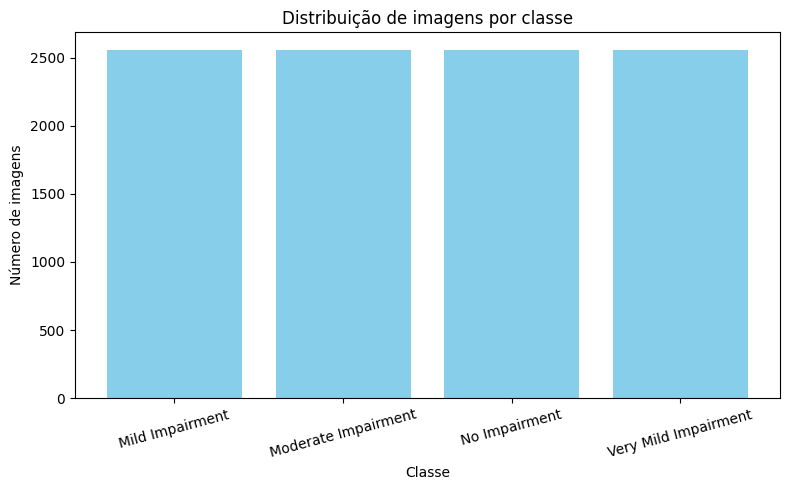

In [ ]:
image_shapes = defaultdict(int)
color_modes = defaultdict(int)
class_counts = {}

for cls in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[cls] = len(images)

    for img_file in images:
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                image_shapes[img.size] += 1
                color_modes[img.mode] += 1
        except Exception as e:
            print(f"Erro ao abrir imagem: {img_path}\n{e}")

print("\nTamanhos de imagem (largura x altura):")
for shape, count in image_shapes.items():
    print(f"{shape}: {count} imagens")

print("\nModos de cor encontrados:")
for mode, count in color_modes.items():
    print(f"{mode}: {count} imagens")

print("\nNúmero de imagens por classe:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classe")
plt.ylabel("Número de imagens")
plt.title("Distribuição de imagens por classe")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



## 🧠 Feature Extraction to Create a dataset to be used in a Machine Learning Modal
First we define labels for the classes in the dataset. The labels are as follows:
- No Impairment': 0,
- Very Mild Impairment': 1,
- Mild Impairment': 2,
- Moderate Impairment': 3


### 🔹 `extract_features(image)`

This function takes a single grayscale image as input and extracts a set of quantitative features:

- **Intensity-based features**:
  - `mean_intensity`: Average pixel value
  - `std_intensity`: Standard deviation of pixel values
  - `min_intensity`: Minimum pixel intensity
  - `max_intensity`: Maximum pixel intensity

- **GLCM (Gray-Level Co-occurrence Matrix) texture features**:
  These capture spatial relationships between pixel intensities:
  - `glcm_contrast`
  - `glcm_dissimilarity`
  - `glcm_homogeneity`
  - `glcm_energy`
  - `glcm_correlation`
  - `glcm_ASM`

- **LBP (Local Binary Pattern) histogram features**:
  Describes local texture patterns around each pixel. The result is a normalized histogram:
  - `lbp_bin_0` to `lbp_bin_10`: 11 bins representing frequency of texture patterns.

The function returns a dictionary where keys are feature names and values are the computed measurements.

Then with the function 'build_dataset' we create a dataset with the features extracted from the images.

This function loops through each class folder in the dataset directory and builds a DataFrame of extracted features:

1. Iterates through class-named subdirectories in `image_dir`.
2. Loads each image in grayscale.
3. Applies `extract_features()` to extract feature values.
4. Appends the class label (both string and numeric) to the result.

Returns a `pandas.DataFrame` with:
- One row per image
- Columns for each extracted feature
- `label_name`: The string label (e.g., `'Mild Impairment'`)
- `label`: The corresponding numeric label (e.g., `2`)

This structured dataset is ready for input into classifiers such as Random Forest, SVM, or Logistic Regression.


In [ ]:
label_encoding = {
    'No Impairment': 0,
    'Very Mild Impairment': 1,
    'Mild Impairment': 2,
    'Moderate Impairment': 3
}

def extract_features(image):
    features = {}
    
    image = image.astype(np.uint8)

    features['mean_intensity'] = np.mean(image)
    features['std_intensity'] = np.std(image)
    features['min_intensity'] = np.min(image)
    features['max_intensity'] = np.max(image)

    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features[f'glcm_{prop}'] = graycoprops(glcm, prop)[0, 0]

    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float") / (hist.sum() + 1e-6)
    for i, h in enumerate(hist):
        features[f'lbp_bin_{i}'] = h

    return features

def build_dataset(image_dir):
    feature_list = []
    label_list = []

    for label_name in sorted(os.listdir(image_dir)):
        if label_name not in label_encoding:
            continue  
        class_path = os.path.join(image_dir, label_name)
        for img_name in tqdm(os.listdir(class_path), desc=f"Processing '{label_name}'"):
            img_path = os.path.join(class_path, img_name)
            image = imread(img_path, as_gray=True)
            features = extract_features(image)
            features['label_name'] = label_name
            features['label'] = label_encoding[label_name]
            feature_list.append(features)
            label_list.append(label_name)

    df = pd.DataFrame(feature_list)
    return df



Here we use the functions defined above to create a .csv file with the features extracted from the images in the dataset. 

In [57]:
dataset_path = 'data/train'
df = build_dataset(dataset_path)
df.to_csv('train_features.csv', index=False)

dataset_path = 'data/val'
df_val = build_dataset(dataset_path)
df_val.to_csv('val_features.csv', index=False)

dataset_path = 'data/test'
df_test = build_dataset(dataset_path)
df_test.to_csv('test_features.csv', index=False)

print("Feature extraction complete. Saved to 'train_features_detailed.csv'.")


Processing 'Very Mild Impairment': 100%|██████████| 448/448 [00:02<00:00, 211.99it/s]

Feature extraction complete. Saved to 'train_features_detailed.csv'.


# Visualization of the new dataset generated from the original dataset (images)

In [ ]:


df = pd.read_csv("train_features_detailed.csv")

sns.set_theme(style="whitegrid", palette="muted")
numeric_features = df.drop(columns=["label", "label_name"])
corr = numeric_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

df['label_name'] = df['label_name'].astype('category')

for feature in ['mean_intensity', 'glcm_contrast', 'lbp_bin_0']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='label_name', y=feature, data=df)
    plt.title(f"{feature} by Diagnosis Category")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

pca = PCA(n_components=2)
X = numeric_features
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['label_name'], palette="Set2")
plt.title("PCA Projection of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


ValueError: could not convert string to float: 'Mild Impairment'

<Figure size 1200x1000 with 0 Axes>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminhos
train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

# Parâmetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

# Apenas normalização (sem augmentation)
datagen = ImageDataGenerator(rescale=1./255)

# Carregar datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Base MobileNetV2 pré-treinada (sem as camadas finais)
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Inicialmente congelar

# Construir modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compilar
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=2, factor=0.5)

# Treinar
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# ➤ FINE-TUNING: Descongela parte da base
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar novamente com fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# Avaliar
loss, acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {acc:.2%}")


Found 10210 images belonging to 4 classes.
Found 3941 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


2025-05-10 00:27:24.773735: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/home/alof/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 179ms/step - accuracy: 0.5852 - loss: 0.9530 - val_accuracy: 0.7668 - val_loss: 0.5703 - learning_rate: 0.0010
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.7205 - loss: 0.6370 - val_accuracy: 0.8056 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 55s 173ms/step - accuracy: 0.7572 - loss: 0.5583 - val_accuracy: 0.7863 - val_loss: 0.4713 - learning_rate: 0.0010
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.7817 - loss: 0.5120 - val_accuracy: 0.7970 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 58s 181ms/step - accuracy: 0.7800 - loss: 0.4924 - val_accuracy: 0.8300 - val_loss: 0.4073 - learning_rate: 0.0010
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step - accuracy: 0.7949 - loss: 0.4780 - val_accuracy: 0.8495 - val_loss: 0.3780 - learning_rate: 0.0010
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 58s 181ms/step - accuracy: 0.7946 - loss: